In [3]:
import numpy as np
import re
import scipy.io
import pandas as pd
import torch
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

## CLEANING TEXT INPUT
First load the mat file from (Wehbe et al 2014) and remove punctuations

In [19]:
subj = 4
final_dict = {}
mat = scipy.io.loadmat('./text_data/subject_'+str(+subj)+'.mat')
run_num = 4
WordsPerTR = 4

words = [mat['words'][0,ii][0][0,0][0] for ii in range(mat['words'].shape[1])]
starts = [mat['words'][0,ii][1][0,0] for ii in range(mat['words'].shape[1])]
TRs = [mat['words'][0,ii][2][0,0] for ii in range(mat['words'].shape[1])]
runIdx  = np.where(mat['time'][:,1]== run_num)[0]

str_tt = 0
end_tt = 0
for tt in runIdx:
    if mat['time'][tt,0]-2 in starts:
        str_tt = tt
        break
for tt in reversed(runIdx):
    if (mat['time'][tt,0]-2 in starts) and (mat['time'][tt,0]-0.5 in starts):
        end_tt = tt
        break

str_ww = starts.index(mat['time'][str_tt,0]-2)
end_ww = starts.index(mat['time'][end_tt,0]-2)
run_data = mat['data'][str_tt:end_tt+1,:]
run_data.shape

words_TR_list = []
words_TR_orgw = []
word_TR_time = []
words_list_list = []
ii = 0
indexes = list(range(str_ww, end_ww+WordsPerTR))
chunks = [indexes[pos:pos + WordsPerTR] for pos in range(0,len(indexes), WordsPerTR)]
for chunk in chunks:
    words_TR_list.append(re.sub('[+\.@-]', '',' '.join([words[ii].replace('"','').replace('\\','') for ii in chunk])))
    words_TR_orgw.append(re.sub('[\.-]', '',' '.join([words[ii].replace('"','').replace('\\','') for ii in chunk])))
    words_list_list.append([words[ii] for ii in chunk])
    word_TR_time.append([starts[ii] for ii in chunk])
    ii += WordsPerTR

#Outputs the chunks of words as a list of lists
words_list_list

sentences_list_list = [[' '.join(words)] for words in words_list_list]

# Flatten the list
sentences = [item for sublist in sentences_list_list for item in sublist]

print(sentences)

['Ron looked at his', 'watch and then glared', 'furiously at Hermione and', 'Neville. + "If either', 'of you get us', "caught, I'll never rest", "until I've learned that", 'Curse of the Bogies', 'Quirrell told us about,', 'and used it on', 'you." + Hermione opened', 'her mouth, perhaps to', 'tell Ron exactly how', 'to use the Curse', 'of the Bogies, but', 'Harry hissed at her', 'to be quiet and', 'beckoned them all forward.', '+ They flitted along', 'corridors striped with bars', 'of moonlight from the', 'high windows. At every', 'turn Harry expected to', 'run into Filch or', 'Mrs. Norris, but they', 'were lucky. They sped', 'up a staircase to', 'the third floor and', 'tiptoed toward the trophy', 'room. + Malfoy and', "Crabbe weren't there yet.", 'The crystal trophy cases', 'glimmered where the moonlight', 'caught them. Cups, shields,', 'plates, and statues winked', 'silver and gold in', 'the darkness. They edged', 'along the walls, keeping', 'their eyes on the', 'doors at either end',

### Initializing The Model
Note that the tokanizer is also model speciifc

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("state-spaces/mamba-130m-hf")
model = AutoModelForCausalLM.from_pretrained("state-spaces/mamba-130m-hf")

EXTRACTING ACTIVATIONS BY RUN (MAMBA)

In [21]:
#Specify what input type you are using: [ cleaned, uncleaned,  average of 4 ]
tpye = "uncleaned"

print("Run " + str(run_num) + " correct ?")

# Prepare the input data
input_texts = sentences
activations = {}

# Process  input sentence
for idx, input_text in enumerate(input_texts):
    
    # Tokenize the input text
    inputs = tokenizer(input_text, return_tensors='pt', add_special_tokens=True)

    # Pass the input through the model with output_hidden_states=True
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)

    # Dictionary to store activations
    activations[f"Sentence_{idx}"] = {}

    # TOKEN LEVEL 
    hidden_states = outputs.hidden_states

    # AVERAGED TOKENS FOR EACH SENTENCE
    #hidden_states = torch.mean(hidden_states, dim=1)
    
    # Store the activations from each layer
    for i, hidden_state in enumerate(hidden_states):
        activations[f"Sentence_{idx}"][f'layer_{i}'] = hidden_state

Run 4 correct ?


SAVING ACTIVATIONS BY RUN (MAMBA)

In [23]:
activations_save_dir=f'./Results/Mamba_130M/Activations/average_of_5_sentences/run{run_num}'

# Calculate the maximum sequence length across all sentences
max_sequence_length = 12
print(activations_save_dir)
# Reorganize the activations by layer
rdm_acts = {}

for ii in range(len(activations.keys())):
    for jj in range(len(activations[f'Sentence_{ii}'].keys())):
        layer_key = f'layer_{jj}'
        if layer_key not in rdm_acts:
            rdm_acts[layer_key] = []

        # Get the current activation
        current_activation = activations[f'Sentence_{ii}'][layer_key]
        
        # Check the shape of current_activation and print debug information
        print(f"Processing Sentence_{ii}, {layer_key}: shape {current_activation.shape}")
        
        # Ensure the second dimension is the sequence length
        if current_activation.shape[1] < max_sequence_length:
            padded_activation = np.pad(
                current_activation, 
                ((0, 0), (0, max_sequence_length - current_activation.shape[1]), (0, 0)), 
                mode='constant'
            )
        else:
            padded_activation = current_activation
        
        # Append to the list
        rdm_acts[layer_key].append(padded_activation)

# Check final shapes before stacking
for key in rdm_acts:
    shapes = [x.shape for x in rdm_acts[key]]
    print(f"Shapes for {key} before stacking: {shapes}")

# Convert lists to numpy arrays
rdm_acts = {k: np.stack(v) for k, v in rdm_acts.items()}

# Save activations to a .npz file with a unique name for each input sentence
save_path = os.path.join(activations_save_dir, f"run{run_num}_all_activations_for_sentences.npz")
np.savez(save_path, **rdm_acts)
print("Activations dict reshaped & saved")

C:/Users/anhoh/OneDrive/Dokumente/Anthea/1_Uni_Informatik/Bachelorarbeit/BA2/BA_Mamba/Notebooks/Results/Mamba_130M/Activations/average_of_5_sentences/run4
Processing Sentence_0, layer_0: shape torch.Size([1, 4, 768])
Processing Sentence_0, layer_1: shape torch.Size([1, 4, 768])
Processing Sentence_0, layer_2: shape torch.Size([1, 4, 768])
Processing Sentence_0, layer_3: shape torch.Size([1, 4, 768])
Processing Sentence_0, layer_4: shape torch.Size([1, 4, 768])
Processing Sentence_0, layer_5: shape torch.Size([1, 4, 768])
Processing Sentence_0, layer_6: shape torch.Size([1, 4, 768])
Processing Sentence_0, layer_7: shape torch.Size([1, 4, 768])
Processing Sentence_0, layer_8: shape torch.Size([1, 4, 768])
Processing Sentence_0, layer_9: shape torch.Size([1, 4, 768])
Processing Sentence_0, layer_10: shape torch.Size([1, 4, 768])
Processing Sentence_0, layer_11: shape torch.Size([1, 4, 768])
Processing Sentence_0, layer_12: shape torch.Size([1, 4, 768])
Processing Sentence_0, layer_13: sha

MERGING ACTIVATIONS FOR ALL RUNS INTO ONE (MAMBA & GPT)

In [64]:
#MERGING ACTIVATIONS for MAMBA FOR SEPARATE RUNS INTO ONE FILE

import numpy as np
import os

merge = "scrambled" #alternatively, "avgd" or "scrambled"
model = "GPT2_137M" # alternatively, "Mamba_130M"
#model = "Mamba_130M"

if model == "GPT2_137M":
    layer_num = 12
else:
    layer_num = 24


# Dateien laden
if merge == "concat":
    run1 = np.load(f"./Results/{model}/Activations/concatenated/run1/run1_all_activations_for_sentences.npz", allow_pickle=True)
    run2 = np.load(f"./Results/{model}/Activations/concatenated/run2/run2_all_activations_for_sentences.npz", allow_pickle=True)
    run3 = np.load(f"./Results/{model}/Activations/concatenated/run3/run3_all_activations_for_sentences.npz", allow_pickle=True)
    run4 = np.load(f"./Results/{model}/Activations/concatenated/run4/run4_all_activations_for_sentences.npz", allow_pickle=True)
    save_path = f"./Results/{model}/Activations/concatenated/concatenated_activations_all_runs.npz"
elif merge == "avgd":
    run1 = np.load(f"./Results/{model}/Activations/average_of_5_sentences/run1/average_activations.npz", allow_pickle=True)
    #run1 = run1["arr_0"][()]
    run2 = np.load(f"./Results/{model}/Activations/average_of_5_sentences/run2/average_activations.npz", allow_pickle=True)
    #run2 = run2["arr_0"][()]
    run3 = np.load(f"./Results/{model}/Activations/average_of_5_sentences/run3/average_activations.npz", allow_pickle=True)
    #run3 = run3["arr_0"][()]
    run4 = np.load(f"./Results/{model}/Activations/average_of_5_sentences/run4/average_activations.npz", allow_pickle=True)
    #run4 = run4["arr_0"][()]
    save_path = f"./Results/{model}/Activations/average_of_5_sentences/avgd_activations_all_runs.npz"
elif merge == "scrambled":
    run1 = np.load(f"./Results/{model}/Activations/scrambled/run1/run1_scrambled_activations.npz", allow_pickle=True)
    run2 = np.load(f"./Results/{model}/Activations/scrambled/run2/run2_scrambled_activations.npz", allow_pickle=True)
    run3 = np.load(f"./Results/{model}/Activations/scrambled/run3/run3_scrambled_activations.npz", allow_pickle=True)
    run4 = np.load(f"./Results/{model}/Activations/scrambled/run4/run4_scrambled_activations.npz", allow_pickle=True)
    save_path = f"./Results/{model}/Activations/scrambled/scrambled_activations_all_runs.npz"
else:
    print("No data loaded")


# Leeres Dictionary, um die neuen Layer-Daten zu speichern
final_layers = {}

def pad_to_max_third_dim(array, max_third_dim):
    padding = [(0, 0), (0, 0), (0, max(0, max_third_dim - array.shape[2])), (0, 0)]
    return np.pad(array, padding, mode='constant')

# Maximum third dimension (12)
max_third_dim = 12

# Iterate over all layers (0-24)
for layer in range(layer_num+1):
    # Load layer data for each run
    layers = [run1[f'layer_{layer}'], run2[f'layer_{layer}'], run3[f'layer_{layer}'], run4[f'layer_{layer}']]

    # Pad layers to have a third dimension of 12
    padded_layers = [pad_to_max_third_dim(layer, max_third_dim) for layer in layers]

    # Concatenate all layers along the first dimension (sentences)
    concatenated_layer = np.concatenate(padded_layers, axis=0)

    # Save the new array
    final_layers[f'layer_{layer}'] = concatenated_layer

# Save the final file
np.savez(save_path, **final_layers)

print("done")


done


MERGING ACTIVATIONS FOR ALL RUNS INTO ONE (FMRI)

In [ ]:
import numpy as np
import os

# Define folder paths
folders = ["./Results/ROIs/Activations/bySubject/subj1", 
"./Results/ROIs/Activations/bySubject/subj2", 
"./Results/ROIs/Activations/bySubject/subj3", 
"./Results/ROIs/Activations/bySubject/subj4", 
"./Results/ROIs/Activations/bySubject/subj5", 
"./Results/ROIs/Activations/bySubject/subj6", 
"./Results/ROIs/Activations/bySubject/subj7", 
"./Results/ROIs/Activations/bySubject/subj8"]

# Base path where subject-specific merged folders are located
output_base_folder = "./Results/ROIs/Activations/bySubject/"

# Function to merge runs within each file
def merge_runs_in_file(file_path):
    data = np.load(file_path, allow_pickle=True)
    merged_runs = []
    
    # Merge the 4 runs
    for run_num in range(1,5):  # Assuming runs are indexed from 0 to 3 (adjust if necessary)
        run_data = data["arr_0"][()][run_num]
        merged_runs.append(run_data)

    # Concatenate the runs along the first axis (adjust axis if needed)
    merged_data = np.concatenate(merged_runs, axis=0)
    
    return merged_data

# Process each folder (subject) separately
for i, folder in enumerate(folders):
    subject_output_folder = os.path.join(output_base_folder, f"merged_subj{i+1}")

    # Process each file in the subject's folder
    for file_name in os.listdir(folder):
        if file_name.endswith(".npz"):  # Ensure processing only npz files
            file_path = os.path.join(folder, file_name)
            
            # Merge the runs within the file
            merged_data = merge_runs_in_file(file_path)
            
            # Save the merged data in the corresponding subject folder
            new_file_name = f"{file_name.split('.')[0]}"
            save_path = os.path.join(subject_output_folder, new_file_name)
            np.savez(save_path, merged_data)


MAMBA - GPT - FMRI - RIDGE REGRESSION

Skipping empty data in: Cerebelum_10_L_subj2.npz
Skipping empty data in: Cerebelum_10_R_subj2.npz
Skipping empty data in: Cerebelum_3_L_subj2.npz
Skipping empty data in: Cerebelum_3_R_subj2.npz
Skipping empty data in: Cerebelum_4_5_L_subj2.npz
Skipping empty data in: Cerebelum_4_5_R_subj2.npz
Skipping empty data in: Cerebelum_6_L_subj2.npz
Skipping empty data in: Cerebelum_6_R_subj2.npz
Skipping empty data in: Cerebelum_7b_L_subj2.npz
Skipping empty data in: Cerebelum_7b_R_subj2.npz
Skipping empty data in: Cerebelum_8_L_subj2.npz
Skipping empty data in: Cerebelum_8_R_subj2.npz
Skipping empty data in: Cerebelum_9_L_subj2.npz
Skipping empty data in: Cerebelum_9_R_subj2.npz
Skipping empty data in: Cerebelum_Crus1_L_subj2.npz
Skipping empty data in: Cerebelum_Crus1_R_subj2.npz
Skipping empty data in: Cerebelum_Crus2_L_subj2.npz
Skipping empty data in: Cerebelum_Crus2_R_subj2.npz
Skipping empty data in: Vermis_10_subj2.npz
Skipping empty data in: Vermis_1_2_subj2.npz
Skipping empty data in:

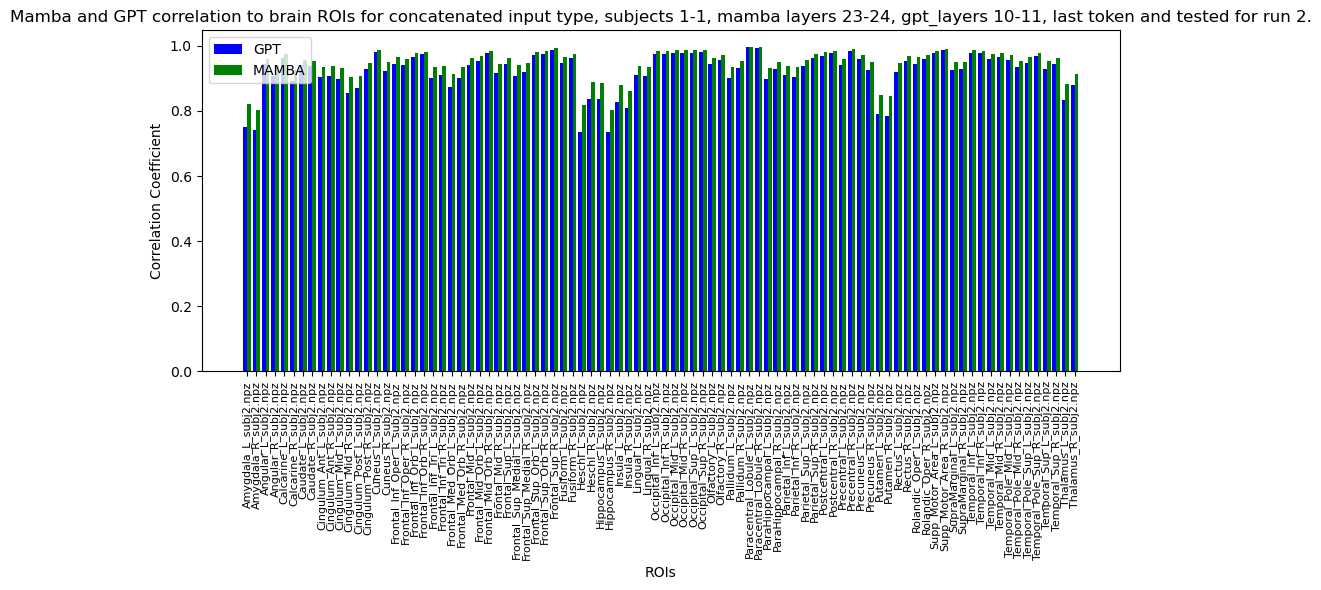

In [82]:
# SPLITING TRAIN-TEST DATA BY RUN

import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

#Load data
mamba_concat = np.load("./Results/Mamba_130M/Activations/concatenated/concatenated_activations_all_runs.npz")
gpt_concat = np.load("./Results/GPT2_137M/Activations/concatenated/concatenated_activations_all_runs.npz")

mamba_5avg = np.load("./Results/Mamba_130M/Activations/average_of_5_sentences/avgd_activations_all_runs.npz")
gpt_5avg = np.load("./Results/GPT2_137M/Activations/average_of_5_sentences/avgd_activations_all_runs.npz")

mamba_scrambled = np.load("./Results/Mamba_130M/Activations/scrambled/scrambled_activations_all_runs.npz")
gpt_scrambled = np.load("./Results/GPT2_137M/Activations/scrambled/scrambled_activations_all_runs.npz")


# Configuration panel

#split specifies test run, 0 stands for split using train_test_split library, split = 1 means we are testing on run 1
split = 2
# if train test split library is used, specify test size (from 0.0-0.99)
test_size = 0.1

#subjects, from 1 - 8. subjects 1,2,4,5,7 supposedly have the lowest noise
subj_num = 2
subject_range_start = 1
subject_range_end = 1

# layers
gpt_single_layer_num = 8
gpt_layer_range_start = 10
gpt_layer_range_end = 11

mamba_single_layer_num = 8
mamba_layer_range_start = 23
mamba_layer_range_end = 24

#alpha
alpha = 1

# dataset
# model_concat: concatenated 4 words, model_scrambled = scrambled 4 words, mamba_5avg = average of 5 sen, model_5scrambled = 5 sen scrambled
mamba_dataset = mamba_scrambled
gpt_dataset = gpt_scrambled
#please fill as well (for chart title)
input_type = "concatenated"

# FMRI Data, incl. subject specification
output_base_folder = f"./Results/ROIs/Activations/bySubject/merged_subj{subj_num}"


# Layer list for selected layerz
gpt_layers = []
mamba_layers = []

#for j in range(mamba_layer_range_start, mamba_layer_range_end+1):
#    mamba_layer = mamba_dataset[f"layer_{j}"]  # GPT has 12 layers
#    mamba_layers.append(mamba_layer[:1291, :, token_range_start, :].reshape(1291, -1))

#for j in range(mamba_layer_range_start, mamba_layer_range_end+1):
mamba_layer = mamba_dataset[f"layer_24"]  # Extract the current Mamba layer
processed_sentences_mamba = []  # Store processed sentences
for sentence in range(1291):  # Loop over sentences
    token_index_list_mamba = []
    for token in range(12):  # Loop over tokens
        # Check if the token contains meaningful values
        if mamba_layer[sentence, 0, token, 0] != mamba_layer[sentence, 0, token, 1]:
            token_index_list_mamba.append(token)
    last_token_mamba = token_index_list_mamba[-1]  # Get the last meaningful token index
    #print(token_index_list_mamba)
    # Extract only the last meaningful token's embeddings
    processed_sentences_mamba.append(mamba_layer[sentence, 0, last_token_mamba, :])  

# Convert the processed sentences back to NumPy format with new shape
processed_layer_mamba = np.array(processed_sentences_mamba).reshape(1291,-1)
#mamba_layers.append(processed_layer_mamba.reshape(1291, -1))  # Append the processed layer


#for j in range(gpt_layer_range_start, gpt_layer_range_end+1):
gpt_layer = gpt_dataset[f"layer_11"]  # GPT has 12 layers
processed_sentences_gpt = []  # Store processed sentences
for sentence in range(1291):  # Loop over sentences
    token_index_list_gpt = []
    for token in range(12):  # Loop over tokens
        # Check if the token contains meaningful values
        if gpt_layer[sentence, 0, token, 0] != gpt_layer[sentence, 0, token, 1]:
            token_index_list_gpt.append(token)
    
    last_token_gpt = token_index_list_gpt[-1]  # Get the last meaningful token index
    #print(token_index_list_gpt)
    # Extract only the last meaningful token's embeddings
    processed_sentences_gpt.append(gpt_layer[sentence, 0, last_token_gpt, :])  

# Convert the processed sentences back to NumPy format with new shape
processed_layer_gpt = np.array(processed_sentences_gpt).reshape(1291, -1)
#gpt_layers.append(processed_layer_gpt.reshape(1291, -1))  # Append the processed layer


# Concatenate all layers for Mamba and GPT
#X_first = np.concatenate(gpt_layers, axis=1)
#X_second = processed_layer_mamba
X_first = processed_layer_gpt
X_second = processed_layer_mamba

# Initialize lists to store correlation results and file names
correlation_coefficients_first = []
correlation_coefficients_second = []
file_names = []

# Standardize X (First = GPT data)
scaler_X_first = StandardScaler()
X_scaled_first = scaler_X_first.fit_transform(X_first)

# Standardize X (Second = Mamba data)
scaler_X_second = StandardScaler()
X_scaled_second = scaler_X_second.fit_transform(X_second)

# Iterate over each fMRI file in the folder
for file_name in os.listdir(output_base_folder):
    if file_name.endswith(".npz"):  # Ensure we only process npz files
        file_path = os.path.join(output_base_folder, file_name)
        
        # Load fMRI data from file (y data)
        fmri_data = np.load(file_path, allow_pickle=True)["arr_0"]
        if fmri_data.shape == (1291, 0):  # Skip files with invalid data
            print("Skipping empty data in:", file_name)
            continue
        
        # Standardize y (fMRI data)
        #scaler_y = StandardScaler()
        y_scaled = fmri_data

        if split == 0:
            # Split data into train and test sets for the first layer
            X_train_first, X_test_first, y_train_first, y_test_first = train_test_split(X_scaled_first, y_scaled, test_size=test_size, random_state=42)

        elif split == 4: 
            #Testen auf Run 4
            X_train_first = X_scaled_first[:926, :]
            X_test_first = X_scaled_first[926:, :]
            y_train_first = y_scaled[:926, :]
            y_test_first = y_scaled[926:, :]

        elif split == 3:
            #Testen auf Run 3
            X_train_first = np.concatenate((X_scaled_first[:662, :], X_scaled_first[926:, :]), axis=0)
            X_test_first = X_scaled_first[662:926, :]
            y_train_first = np.concatenate((y_scaled[:662, :], y_scaled[926:, :]), axis=0)
            y_test_first = y_scaled[662:926, :]

        elif split == 2:  
            # Testen auf Run 2
            X_train_first = np.concatenate((X_scaled_first[:325, :], X_scaled_first[662:, :]), axis=0)
            X_test_first = X_scaled_first[325:662, :]
            y_train_first = np.concatenate((y_scaled[:325, :], y_scaled[662:, :]), axis=0)
            y_test_first = y_scaled[325:662, :]

        elif split == 1:
            # # Testen auf Run 1
            X_train_first = X_scaled_first[325:, :]
            X_test_first = X_scaled_first[:325, :]
            y_train_first = y_scaled[325:, :]
            y_test_first = y_scaled[:325, :]
        
        else:
            print("Split for first set incorrectly specified.")    
       
        # Perform ridge regression for the first layer
        ridge_model_first = RidgeCV()
        ridge_model_first.fit(X_train_first, y_train_first)
        predictions_first = ridge_model_first.predict(X_test_first)
        
        # Calculate Pearson correlation coefficient for the first layer
        corr_coefficient_first, _ = pearsonr(y_test_first.flatten(), predictions_first.flatten())
        correlation_coefficients_first.append(corr_coefficient_first)
        
        if split == 0:
            # Split data into train and test sets for the second layer
            X_train_second, X_test_second, y_train_second, y_test_second = train_test_split(X_scaled_second, y_scaled, test_size=test_size, random_state=42)

        elif split == 4:
            #Testen auf Run 4
            X_train_second = X_scaled_second[:926, :]
            X_test_second = X_scaled_second[926:, :]
            y_train_second = y_scaled[:926, :]
            y_test_second = y_scaled[926:, :]

        elif split == 3:
            #Testen auf Run 3
            X_train_second = np.concatenate((X_scaled_second[:662, :], X_scaled_second[926:, :]), axis=0)
            X_test_second = X_scaled_second[662:926, :]
            y_train_second = np.concatenate((y_scaled[:662, :], y_scaled[926:, :]), axis=0)
            y_test_second = y_scaled[662:926, :]

        elif split == 2:
            # Testen auf Run 2
            X_train_second = np.concatenate((X_scaled_second[:325, :], X_scaled_second[662:, :]), axis=0)
            X_test_second = X_scaled_second[325:662, :]
            y_train_second = np.concatenate((y_scaled[:325, :], y_scaled[662:, :]), axis=0)
            y_test_second = y_scaled[325:662, :]

        elif split == 1:
            # #Testen auf Run 1
            X_train_second = X_scaled_second[325:, :]
            X_test_second = X_scaled_second[:325, :]
            y_train_second = y_scaled[325:, :]
            y_test_second = y_scaled[:325, :]

        else:
            print("Split for second set specified incorrectly")
            
        # Perform ridge regression for the second layer
        ridge_model_second = Ridge(alpha=alpha)
        ridge_model_second.fit(X_train_second, y_train_second)
        predictions_second = ridge_model_second.predict(X_test_second)
        
        # Calculate Pearson correlation coefficient for the second layer
        corr_coefficient_second, _ = pearsonr(y_test_second.flatten(), predictions_second.flatten())
        correlation_coefficients_second.append(corr_coefficient_second)
        
        file_names.append(file_name)  # Only append file name if the data is valid

# Check if we have valid data to plot
if correlation_coefficients_first or correlation_coefficients_second:
    # Plotting the correlation coefficients for each file
    fig, ax = plt.subplots(figsize=(10, 6))

    file_indices = np.arange(len(file_names))  # X-axis positions for files

    # Plot correlation coefficients for the first layer
    ax.bar(file_indices - 0.2, correlation_coefficients_first, width=0.4, color='b', label='GPT')

    # Plot correlation coefficients for the second layer
    ax.bar(file_indices + 0.2, correlation_coefficients_second, width=0.4, color='g', label='MAMBA')

    # Set file names as x-axis labels
    ax.set_xticks(file_indices)
    ax.set_xticklabels(file_names, rotation=90, fontsize=8)  # Rotate labels for better readability

    ax.set_xlabel('ROIs')
    ax.set_ylabel('Correlation Coefficient')
    ax.set_title(f'Mamba and GPT correlation to brain ROIs for {input_type} input type, subjects {subject_range_start}-{subject_range_end}, mamba layers {mamba_layer_range_start}-{mamba_layer_range_end}, gpt_layers {gpt_layer_range_start}-{gpt_layer_range_end}, last token and tested for run {split}.')
    ax.legend()

    plt.tight_layout()
    # plt.show()
else:
    print("No valid data to plot.")